In [180]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.applications import EfficientNetB0

In [181]:
dataset_dir= r"C:\Users\asuss\OneDrive\Desktop\archive\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [182]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [183]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


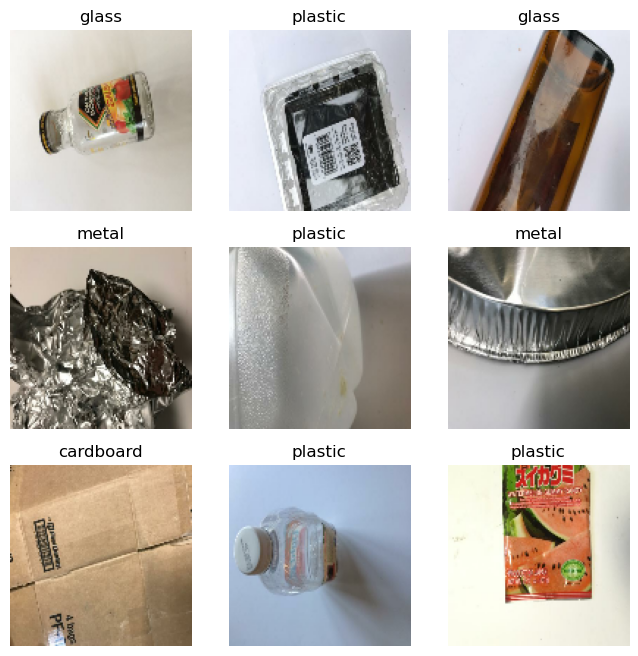

In [184]:
class_names = train_ds.class_names
print("Classes:",class_names)

plt.figure(figsize=(8,8))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [185]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetB0(include_top=False, input_shape=(124, 124, 3), weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [186]:

model = models.Sequential([
    keras.Input(shape=(124,124,3)),
    layers.Rescaling(1./255),  # normalize pixel values

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # output neurons = number of classes
])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)             │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 122, 122, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 59, 59, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,863,046 (10.92 MB)

 Trainable params: 2,863,046 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
train_class_counts = dict.fromkeys(train_ds.class_names, 0)
val_class_counts = dict.fromkeys(val_ds.class_names, 0)

# Count in train set
for images, labels in train_ds.unbatch():
    label = labels.numpy()
    class_name = train_ds.class_names[label]
    train_class_counts[class_name] += 1

# Count in validation set
for images, labels in val_ds.unbatch():
    label = labels.numpy()
    class_name = val_ds.class_names[label]
    val_class_counts[class_name] += 1

print("Train set distribution:", train_class_counts)
print("Validation set distribution:", val_class_counts)

Train set distribution: {'cardboard': 334, 'glass': 399, 'metal': 322, 'paper': 471, 'plastic': 393, 'trash': 103}
Validation set distribution: {'cardboard': 69, 'glass': 102, 'metal': 88, 'paper': 123, 'plastic': 89, 'trash': 34}


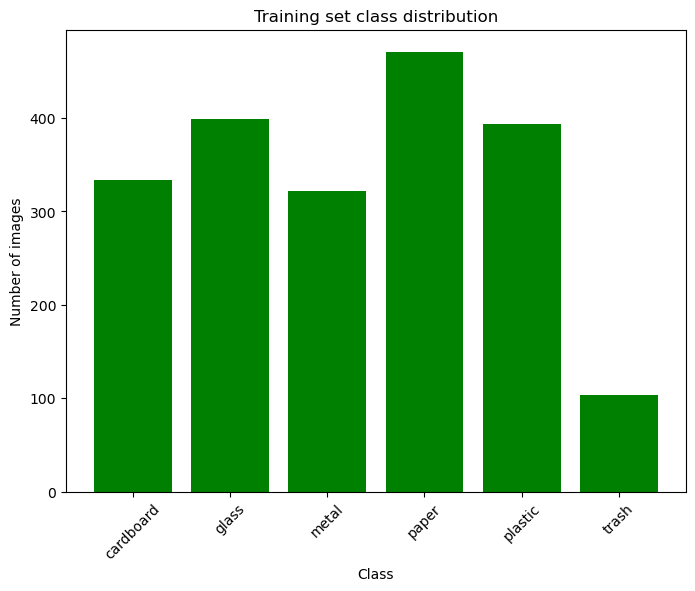

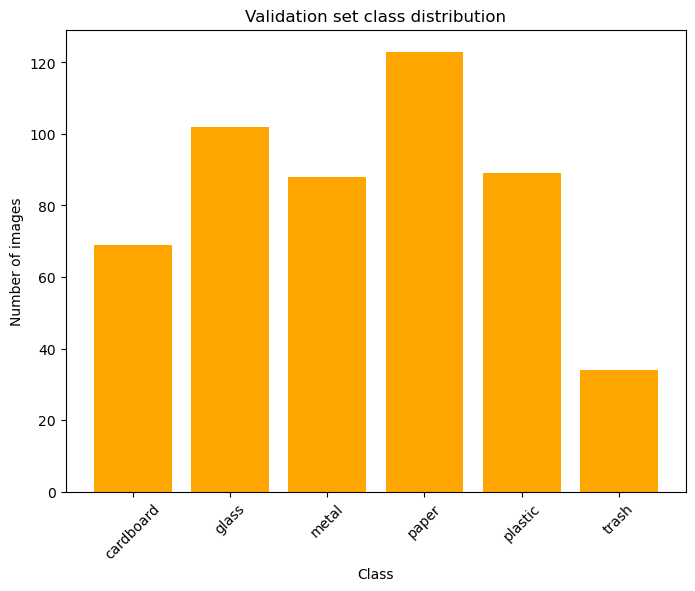

In [188]:
# Training set
plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='green')
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Training set class distribution")
plt.xticks(rotation=45)
plt.show()

# Validation set
plt.figure(figsize=(8, 6))
plt.bar(val_class_counts.keys(), val_class_counts.values(), color='orange')
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Validation set class distribution")
plt.xticks(rotation=45)
plt.show()

In [189]:
for i, c in enumerate("history = model.fit(train_data, validation_data=val_data, epochs=10)"):
    if not c.isprintable():
        print(f"Bad character at index {i}: {repr(c)}")

In [190]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' depending on your labels
    metrics=['accuracy']
)

In [191]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.2953 - loss: 1.6838 - val_accuracy: 0.4158 - val_loss: 1.4383
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.4325 - loss: 1.4002 - val_accuracy: 0.4614 - val_loss: 1.3499
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.4752 - loss: 1.2889 - val_accuracy: 0.4832 - val_loss: 1.3364
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.5436 - loss: 1.1847 - val_accuracy: 0.5168 - val_loss: 1.1991
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.5679 - loss: 1.1185 - val_accuracy: 0.5149 - val_loss: 1.1661
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.6030 - loss: 1.0580 - val_accuracy: 0.5624 - val_loss: 1.1736
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6270 - loss: 0.9694 - val_accuracy: 0.5980 - val_loss: 1.1138
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6763 - loss: 0.8892 - val_accu

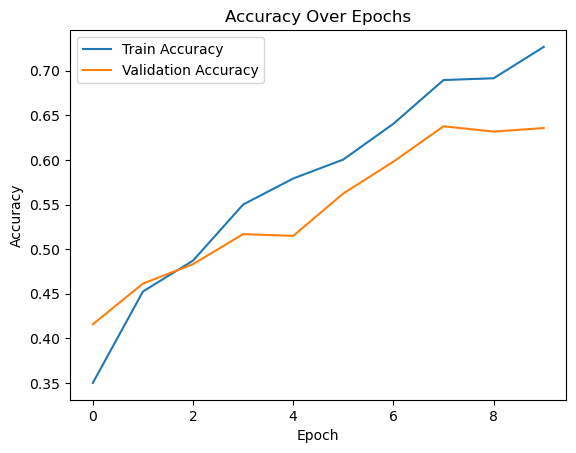

In [192]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()